In [428]:
import numpy as np
import scipy
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

def RosslerEqs(t,X,a,b,c):
    x = X[0]
    y = X[1]
    z = X[2]
    x_dot = -y-z
    y_dot = x+a*y
    z_dot = -c*z+x*z+b
    return [x_dot,y_dot,z_dot]

def simulateRosslerSystem(X0,Deltat_sim,gridDensity,a,b,c):
    # numerical integration
    t_span = [0,Deltat_sim]
    t_eval = np.linspace(0,Deltat_sim,gridDensity*Deltat_sim+1)
    soln = scipy.integrate.solve_ivp(RosslerEqs,t_span,X0,args=[a,b,c],method="RK45",t_eval=t_eval)
    t = soln.t
    [x,y,z] = soln.y
    # exact derivatives from simulation
    x_dot = []
    y_dot = []
    z_dot = []
    for i in range(0,len(t)):
        X = [x[i],y[i],z[i]]
        [dxdt,dydt,dzdt] = RosslerEqs(t,X,a,b,c)
        x_dot.append(dxdt)
        y_dot.append(dydt)
        z_dot.append(dzdt)
    # log data
    t_out = np.array(t).reshape(len(t),1)
    x = np.array(x).reshape(len(t),1)
    y = np.array(y).reshape(len(t),1)
    z = np.array(z).reshape(len(t),1)
    X_out = np.hstack([x,y,z])
    x_dot = np.array(x_dot).reshape(len(t),1)
    y_dot = np.array(y_dot).reshape(len(t),1)
    z_dot = np.array(z_dot).reshape(len(t),1)
    X_dot_out = np.hstack([x_dot,y_dot,z_dot])
    return [t_out,X_out,X_dot_out]

# ---library---
def calcTheta_Lorenz(arr_t,arr_x,arr_y,arr_z):
    Theta = np.zeros([len(arr_t),10])
    for i in range(0,len(arr_t)):
        x = arr_x[i]
        y = arr_y[i]
        z = arr_z[i]
        Theta[i,0] = 1
        Theta[i,1] = x
        Theta[i,2] = y
        Theta[i,3] = z
        Theta[i,4] = x**2
        Theta[i,5] = y**2
        Theta[i,6] = z**2
        Theta[i,7] = x*y
        Theta[i,8] = y*z
        Theta[i,9] = x*z
    return Theta

# ---sparse regression---
def sparseRegression_prescribedLambda(A,b,params_regression):
    method = params_regression["method"]
    if method == "least-squares":
        N_loops = params_regression["N_loops"]
        lambda_sparse = params_regression["lambda_sparse"]
        x = np.linalg.pinv(A)@b
        x = x.flatten()
        b = b.flatten()
        for i in range(1,N_loops+1):
            smallInds = abs(x)<lambda_sparse
            x[smallInds] = 0
            bigInds = ~smallInds 
            x[bigInds] = np.linalg.pinv(A[:,bigInds])@b
    elif method == "ridge":
        N_loops = params_regression["N_loops"]
        lambda_sparse = params_regression["lambda_sparse"]
        lambda_ridge = params_regression["lambda_ridge"]
        x = np.linalg.solve(A.T@A+lambda_ridge*np.eye(A.shape[1]),A.T@b)
        x = x.flatten()
        b = b.flatten()
        for i in range(1,N_loops+1):
            smallInds = abs(x)<lambda_sparse
            x[smallInds] = 0
            bigInds = ~smallInds 
            x[bigInds] = np.linalg.solve(A[:,bigInds].T@A[:,bigInds]+lambda_ridge*np.eye(A[:,bigInds].shape[1]),A[:,bigInds].T@b)
    elif method == "lasso":
        lambda_lasso = params_regression["lambda_lasso"]
        lasso = Lasso(alpha=lambda_lasso)
        lasso.fit(A,b)
        x = lasso.coef_
    x = x.reshape(-1,1)
    return x

def calcL(A,w_lambda,w0):
    accuracyCost = np.linalg.norm(A@w_lambda-A@w0)/np.linalg.norm(A@w0)
    sparsityCost = np.sum(w_lambda!=0)/A.shape[1]
    return accuracyCost+sparsityCost

def sparseRegression_autoLambda(A,b,params_regression):
    # compute w0
    if params_regression["method"] == "least-squares":
        w0 = np.linalg.pinv(A)@b
    elif params_regression["method"] == "ridge":
        lambda_ridge = params_regression["lambda_ridge"]
        w0 = np.linalg.solve(A.T@A+lambda_ridge*np.eye(A.shape[1]),A.T@b)
    # compute the optimal w_lambda
    arr_lambda = np.logspace(-5,0,51)
    arr_w_lambda = np.zeros((A.shape[1],51))
    arr_L = np.zeros(arr_lambda.shape)
    for i in range(0,len(arr_lambda)):
        params_regression["lambda_sparse"] = arr_lambda[i]
        w_lambda = sparseRegression_prescribedLambda(A,b,params_regression)
        arr_w_lambda[:,i] = w_lambda.flatten()
        arr_L[i] = calcL(A,w_lambda,w0)
    ind = np.argmin(arr_L)
    w_out = arr_w_lambda[:,ind]
    return w_out.reshape(-1,1)

# ---regular SINDy---
# central finite difference
def calcDerivatives(t_out,X_out):
    Deltat = np.diff(t_out.reshape(1,len(t_out)))
    Deltax = np.diff(X_out[:,0].reshape(1,len(t_out)))
    Deltay = np.diff(X_out[:,1].reshape(1,len(t_out)))
    Deltaz = np.diff(X_out[:,2].reshape(1,len(t_out)))
    t_out = t_out[1:-1]
    X_out = X_out[1:-1,:]
    # forward step size
    a = Deltat[0,1:]
    Deltax_fwd = Deltax[0,1:]
    Deltay_fwd = Deltay[0,1:]
    Deltaz_fwd = Deltaz[0,1:]
    # backward step size
    b = Deltat[0,0:-1]
    Deltax_bwd = Deltax[0,0:-1]
    Deltay_bwd = Deltay[0,0:-1]
    Deltaz_bwd = Deltaz[0,0:-1]
    # derivatives
    x_dot = (b**2*Deltax_fwd+a**2*Deltax_bwd)/(a**2*b+a*b**2)
    y_dot = (b**2*Deltay_fwd+a**2*Deltay_bwd)/(a**2*b+a*b**2)
    z_dot = (b**2*Deltaz_fwd+a**2*Deltaz_bwd)/(a**2*b+a*b**2)
    x_dot = x_dot.reshape(len(x_dot),1)
    y_dot = y_dot.reshape(len(y_dot),1)
    z_dot = z_dot.reshape(len(z_dot),1)
    return x_dot,y_dot,z_dot

# SINDy
def SINDy_Lorenz(t_out,X_out,params_regression):
    x_dot,y_dot,z_dot = calcDerivatives(t_out,X_out)
    Theta = calcTheta_Lorenz(t_out[1:-1],X_out[1:-1,0],X_out[1:-1,1],X_out[1:-1,2])
    if params_regression["lambda_sparse"] == "auto":
        w1 = sparseRegression_autoLambda(Theta,x_dot,params_regression)
        w2 = sparseRegression_autoLambda(Theta,y_dot,params_regression)
        w3 = sparseRegression_autoLambda(Theta,z_dot,params_regression)
    else:
        w1 = sparseRegression_prescribedLambda(Theta,x_dot,params_regression)
        w2 = sparseRegression_prescribedLambda(Theta,y_dot,params_regression)
        w3 = sparseRegression_prescribedLambda(Theta,z_dot,params_regression)

    w = np.hstack([w1,w2,w3])
    return w

# ---weak SINDy---
# bump test functions
def func_phi_bump(t,p,q,a,b):
    C = 1/(p**p*q**q)*((p+q)/(b-a))**(p+q)
    phi = C*(t-a)**p*(b-t)**q
    return phi
def func_phi_dot_bump(t,p,q,a,b):
    C = 1/(p**p*q**q)*((p+q)/(b-a))**(p+q)
    phi_dot = C*p*(t-a)**(p-1)*(b-t)**q-C*q*(t-a)**p*(b-t)**(q-1)
    return phi_dot

# bump weak SINDy
def WSINDy_bump_Lorenz(t_out,X_out,N_p,N_q,params_regression):
    # library
    Theta = calcTheta_Lorenz(t_out,X_out[:,0],X_out[:,1],X_out[:,2])
    # test function parameters
    array_p = np.linspace(1,100,N_p)
    array_q = np.linspace(1,100,N_q)
    # find V and V_dot for Riemann sums
    Deltat = np.diff(t_out.reshape(1,len(t_out)))
    V_L = np.zeros([N_p*N_q,len(t_out)-1])
    V_R = np.zeros([N_p*N_q,len(t_out)-1])
    V_dot_L = np.zeros([N_p*N_q,len(t_out)-1])
    V_dot_R = np.zeros([N_p*N_q,len(t_out)-1])
    for n_p in range(0,N_p):
        for n_q in range(0,N_q):
            p = array_p[n_p]
            q = array_q[n_q]
            m = n_p*N_q+n_q   #(m+1)-th test function with index m
            # V_L for left Riemann sum
            Phi_L_m = func_phi_bump(t_out[0:-1],p,q,t_out[0],t_out[-1])
            Phi_L_m = Phi_L_m.reshape(1,len(Phi_L_m))
            V_L[m,:] = Deltat*Phi_L_m
            # V_R for right Riemann sum
            Phi_R_m = func_phi_bump(t_out[1:],p,q,t_out[0],t_out[-1])
            Phi_R_m = Phi_R_m.reshape(1,len(Phi_R_m))
            V_R[m,:] = Deltat*Phi_R_m
            # V_dot_L for left Riemann sum
            Phi_dot_L_m = func_phi_dot_bump(t_out[0:-1],p,q,t_out[0],t_out[-1])
            Phi_dot_L_m = Phi_dot_L_m.reshape(1,len(Phi_dot_L_m))
            V_dot_L[m,:] = Deltat*Phi_dot_L_m
            # V_dot_R for right Riemann sum
            Phi_dot_R_m = func_phi_dot_bump(t_out[1:],p,q,t_out[0],t_out[-1])
            Phi_dot_R_m = Phi_dot_R_m.reshape(1,len(Phi_dot_R_m))
            V_dot_R[m,:] = Deltat*Phi_dot_R_m
    # compute A and b from trapezoid integral
    ## A
    A_L = V_L@Theta[0:-1,:]
    A_R = V_R@Theta[1:,:]
    A_trapz = (A_L+A_R)/2
    ## b1
    b1_L = -V_dot_L@X_out[0:-1,0]
    b1_R = -V_dot_R@X_out[1:,0]
    b1_trapz = (b1_L+b1_R)/2
    ## b2
    b2_L = -V_dot_L@X_out[0:-1,1]
    b2_R = -V_dot_R@X_out[1:,1]
    b2_trapz = (b2_L+b2_R)/2
    ## b3
    b3_L = -V_dot_L@X_out[0:-1,2]
    b3_R = -V_dot_R@X_out[1:,2]
    b3_trapz = (b3_L+b3_R)/2
    # sparse regression
    if params_regression["lambda_sparse"] == "auto":
        w1 = sparseRegression_autoLambda(A_trapz,b1_trapz,params_regression)
        w2 = sparseRegression_autoLambda(A_trapz,b2_trapz,params_regression)   
        w3 = sparseRegression_autoLambda(A_trapz,b3_trapz,params_regression)
    else:
        w1 = sparseRegression_prescribedLambda(A_trapz,b1_trapz,params_regression)
        w2 = sparseRegression_prescribedLambda(A_trapz,b2_trapz,params_regression)   
        w3 = sparseRegression_prescribedLambda(A_trapz,b3_trapz,params_regression)

    w = np.hstack([w1,w2,w3])
    return w

# Fourier test functions
def func_phi_Fourier(t,n,t_a,t_b):
    omega0 = 2*np.pi/(t_b-t_a)
    omega = n*omega0
    phi_cos = np.cos(omega*(t-t_a))
    phi_sin = np.sin(omega*(t-t_a))
    return phi_cos,phi_sin

def func_phi_dot_Fourier(t,n,t_a,t_b):
    omega0 = 2*np.pi/(t_b-t_a)
    omega = n*omega0
    phi_cos_dot = -omega*np.sin(omega*(t-t_a))
    phi_sin_dot = omega*np.cos(omega*(t-t_a))
    return phi_cos_dot,phi_sin_dot

# Fourier weak SINDy
def constructLS_Fourier(t_out,x_i,array_n,Theta):
    Deltat = t_out[1]-t_out[0]
    N_n = len(array_n)
    # find V and V_dot for Riemann sums
    V_L = np.zeros([N_n,len(t_out)-1])
    V_R = np.zeros([N_n,len(t_out)-1])
    V_dot_L = np.zeros([N_n,len(t_out)-1])
    V_dot_R = np.zeros([N_n,len(t_out)-1])
    for n_n in range(0,N_n):
        n = array_n[n_n]
        # V_L for left Riemann sum
        Phi_L_n_cos,Phi_L_n_sin = func_phi_Fourier(t_out[0:-1],n,t_out[0],t_out[-1])
        Phi_L_n_sin = Phi_L_n_sin.reshape(1,len(Phi_L_n_sin))
        V_L[n_n,:] = Deltat*Phi_L_n_sin
        # V_R for right Riemann sum
        Phi_R_n_cos,Phi_R_n_sin = func_phi_Fourier(t_out[1:],n,t_out[0],t_out[-1])
        Phi_R_n_sin = Phi_R_n_sin.reshape(1,len(Phi_R_n_sin))
        V_R[n_n,:] = Deltat*Phi_R_n_sin
        # V_dot_L for left Riemann sum
        Phi_dot_L_n_cos,Phi_dot_L_n_sin = func_phi_dot_Fourier(t_out[0:-1],n,t_out[0],t_out[-1])
        Phi_dot_L_n_sin = Phi_dot_L_n_sin.reshape(1,len(Phi_dot_L_n_sin))
        V_dot_L[n_n,:] = Deltat*Phi_dot_L_n_sin
        # V_dot_R for right Riemann sum
        Phi_dot_R_n_cos,Phi_dot_R_n_sin = func_phi_dot_Fourier(t_out[1:],n,t_out[0],t_out[-1])
        Phi_dot_R_n_sin = Phi_dot_R_n_sin.reshape(1,len(Phi_dot_R_n_sin))
        V_dot_R[n_n,:] = Deltat*Phi_dot_R_n_sin    
    # compute A and b for trapezoid integral
    ## A
    A_L = V_L@Theta[0:-1,:]
    A_R = V_R@Theta[1:,:]
    A_trapz = (A_L+A_R)/2
    ## b
    b_L = -V_dot_L@x_i[0:-1]
    b_R = -V_dot_R@x_i[1:]
    b_trapz = (b_L+b_R)/2

    return A_trapz,b_trapz

def constructLS_Fourier_FFT(t_out,x_i,array_n,Theta):
    Deltat = t_out[1]-t_out[0]
    N = len(t_out.flatten())
    omega0 = 2*np.pi/(t_out[-1]-t_out[0])

    # compute Fourier coefficients for state variable
    f_hat_x_i = np.fft.fft(x_i.flatten())   # FFT
    f_hat_x_i = f_hat_x_i/N   # Fourier coefficients
    a_n_x_i = 2*f_hat_x_i.real
    b_n_x_i = -2*f_hat_x_i.imag

    # compute Fourier coefficients for dictionary terms
    a_n_Theta = np.zeros((len(t_out),Theta.shape[1]))
    b_n_Theta = np.zeros((len(t_out),Theta.shape[1]))
    for i in range(0,Theta.shape[1]):
        f_hat = np.fft.fft(Theta[:,i].flatten())    # FFT
        f_hat = f_hat/N   # Fourier coefficients
        a_n_Theta[:,i] = 2*f_hat.real
        b_n_Theta[:,i] = -2*f_hat.imag

    # compute A and b
    N_n = len(array_n)
    # A = np.vstack([a_n_Theta[1:N_n+1,:],b_n_Theta[1:N_n+1,:]])
    # b_cos = np.zeros((N_n,1))
    # b_sin = np.zeros((N_n,1))
    # for i in range(0,N_n):
    #     n = i+1
    #     b_cos[i] = x_i[-1]-x_i[0]+n*omega0*b_n_x_i[n]
    #     b_sin[i] = -n*omega0*a_n_x_i[n]
    # b = np.vstack([b_cos,b_sin])

    A = b_n_Theta[1:N_n+1,:]
    b = np.zeros((N_n,1))
    for i in range(0,N_n):
        n = i+1
        b[i] = -n*omega0*a_n_x_i[n]

    # A = a_n_Theta[1:N_n+1,:]
    # b = np.zeros((N_n,1))
    # for i in range(0,N_n):
    #     n = i+1
    #     b[i] = x_i[-1]-x_i[0]+n*omega0*b_n_x_i[n]

    return A,b

def WSINDy_Fourier_Lorenz(t_out,X_out,N_freq,params_regression):
    omega0 = 2*np.pi/(t_out[-1]-t_out[0])
    arr_x = X_out[:,0]
    arr_y = X_out[:,1]
    arr_z = X_out[:,2]
    # set n-values
    arr_n_x = np.linspace(1,N_freq,N_freq)
    arr_n_y = np.linspace(1,N_freq,N_freq)
    arr_n_z = np.linspace(1,N_freq,N_freq)
    # library
    Theta = calcTheta_Lorenz(t_out,arr_x,arr_y,arr_z)
    # A and b
    A1,b1 = constructLS_Fourier(t_out,arr_x,arr_n_x,Theta)
    A2,b2 = constructLS_Fourier(t_out,arr_y,arr_n_y,Theta)
    A3,b3 = constructLS_Fourier(t_out,arr_z,arr_n_z,Theta)
    # sparse regressions
    if params_regression["lambda_sparse"] == "auto":
        w1 = sparseRegression_autoLambda(A1,b1,params_regression)
        w2 = sparseRegression_autoLambda(A2,b2,params_regression)
        w3 = sparseRegression_autoLambda(A3,b3,params_regression)
    else:
        w1 = sparseRegression_prescribedLambda(A1,b1,params_regression)
        w2 = sparseRegression_prescribedLambda(A2,b2,params_regression)
        w3 = sparseRegression_prescribedLambda(A3,b3,params_regression)

    w = np.hstack([w1,w2,w3])
    return w

def WSINDy_Fourier_FFT_Lorenz(t_out,X_out,N_freq,params_regression):
    omega0 = 2*np.pi/(t_out[-1]-t_out[0])
    arr_x = X_out[:,0]
    arr_y = X_out[:,1]
    arr_z = X_out[:,2]
    # set n-values
    arr_n_x = np.linspace(1,N_freq,N_freq)
    arr_n_y = np.linspace(1,N_freq,N_freq)
    arr_n_z = np.linspace(1,N_freq,N_freq)
    # library
    Theta = calcTheta_Lorenz(t_out,arr_x,arr_y,arr_z)
    # A and b
    A1,b1 = constructLS_Fourier_FFT(t_out,arr_x,arr_n_x,Theta)
    A2,b2 = constructLS_Fourier_FFT(t_out,arr_y,arr_n_y,Theta)
    A3,b3 = constructLS_Fourier_FFT(t_out,arr_z,arr_n_z,Theta)
    # sparse regressions
    if params_regression["lambda_sparse"] == "auto":
        w1 = sparseRegression_autoLambda(A1,b1,params_regression)
        w2 = sparseRegression_autoLambda(A2,b2,params_regression)
        w3 = sparseRegression_autoLambda(A3,b3,params_regression)
    else:
        w1 = sparseRegression_prescribedLambda(A1,b1,params_regression)
        w2 = sparseRegression_prescribedLambda(A2,b2,params_regression)
        w3 = sparseRegression_prescribedLambda(A3,b3,params_regression)

    w = np.hstack([w1,w2,w3])
    return w

# ---error evaluations---
def errorEval(w_true,w_ident):
    # relative error norm
    e = w_true-w_ident
    errorNorm = np.linalg.norm(e,"fro")
    errorNorm_rel = errorNorm/np.linalg.norm(w_true,"fro")
    # spurious terms and terms failed to be identified
    N_spurious = np.sum((w_true==0) & (w_ident!=0))
    N_failed = np.sum((w_true!=0) & (w_ident==0))
    # TPR
    N_correct = np.sum((w_true==0) & (w_ident==0))
    TPR = N_correct/(N_correct+N_spurious+N_failed)   
    return errorNorm_rel,TPR

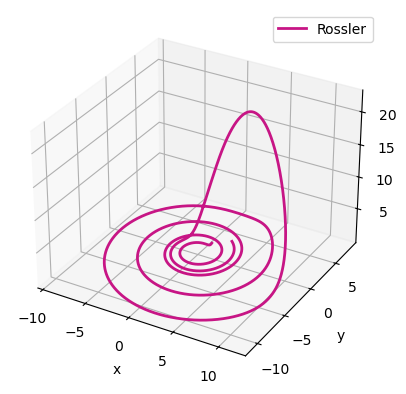

In [429]:
# ---simulate Rossler system---
a = 0.2
b = 0.2
c = 5.7

w_true = np.zeros((10,3))
w_true[2,0] = -1
w_true[3,0] = -1
w_true[1,1] = 1
w_true[2,1] = a
w_true[0,2] = b
w_true[3,2] = -c
w_true[9,2] = 1

X0 = np.array([1,1,1])
t_sim = 30
t_span = [0,t_sim]
t_out,X_out,XD_out = simulateRosslerSystem(X0,t_sim,10000,a,b,c)
x = X_out[:,0]
y = X_out[:,1]
z = X_out[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z, label='Rossler', color='mediumvioletred', linewidth=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()

plt.show()

In [430]:
w_true

array([[ 0. ,  0. ,  0.2],
       [ 0. ,  1. ,  0. ],
       [-1. ,  0.2,  0. ],
       [-1. ,  0. , -5.7],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ]])

In [431]:
params_regression = dict()
params_regression["method"] = "ridge"
params_regression["lambda_sparse"] = 0.01
params_regression["lambda_ridge"] = 0.001
params_regression["N_loops"] = 100

w_ident = SINDy_Lorenz(t_out,X_out,params_regression)

w_ident

array([[ 0.        ,  0.        ,  0.20169921],
       [ 0.        ,  1.0000045 ,  0.        ],
       [-1.00000393,  0.20000355,  0.        ],
       [-0.99996564,  0.        , -5.73814947],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.00540494]])

In [435]:
params_regression = dict()
params_regression["method"] = "ridge"
params_regression["lambda_sparse"] = 0.01
params_regression["lambda_ridge"] = 0.001
params_regression["N_loops"] = 100
startTime = time.perf_counter()
w_ident = WSINDy_Fourier_FFT_Lorenz(t_out,X_out,60,params_regression)
endTime = time.perf_counter()
timeConsumed = endTime-startTime
print(f"w_ident =")
print(w_ident)
print(f"{timeConsumed} s consumed")

w_ident =
[[ 0.          0.          0.        ]
 [ 0.          0.99980899  0.        ]
 [-0.99997117  0.19993735  0.        ]
 [-0.99982418  0.         -5.7354924 ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          1.00501729]]
1.8144647000008263 s consumed
